In [8]:
import csv
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from openpyxl import load_workbook
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Сперва считаем данные и разделим их по полу

#### Считываем таблицу с данными для задачи

In [41]:
data = pd.read_csv('data.csv', delimiter=',')

Отделяем важные признаки: оценка за экзамен, оценка за контрольную и пол студента

In [23]:
v = data[["exam_9","midterm_9", "female_9"]].copy()
v["exam_9"] = v["exam_9"].apply(lambda x : str(x).replace(',', '.'))
v['midterm_9'] = v['midterm_9'].apply(lambda x : str(x).replace(',', '.'))
v[["exam_9", "midterm_9"]] = v[["exam_9", "midterm_9"]].apply(pd.to_numeric)

#### Отдельно выделяем две таблицы, где только мальчики и только девочки.
В соответствующих таблицах - men, women

In [24]:
men = v[v["female_9"] == 0]

In [25]:
women = v[v["female_9"] == 1]

## Далее будем 	оценивать уравнение $$exam_i=β_1+β_2midterm_i+ϵ_i$$ по данным о юношах и девушках и рассчитывать коэффициент детерминации R^2. 

## Функция для вычисления коэффициента детерминации.
### Сначала вычисляются средние значения для оценки за экзамен и за контрольную работу. Далее x обозначает оценку за к/р и целевая переменная y - оценка за экзамен. 
 Для оценки модели $y = b_1 + b_2 \cdot x$ вычислим коэффициенты $b_1$ и $b_2$.
 
$b_2 = \frac{\sum{(x - \overline{x}) \cdot (y - \overline{y})}}{\sum{(x - \overline{x})^2}}$

Тогда $b_1 = \overline{y} - b_2 \cdot \overline{x}$

$ESS = \sum{(\hat{y} - \overline{y})^2}$ 

$TSS = \sum{(y - \overline{y})^2}$

$R^2 = \frac{ESS}{TSS}$

In [26]:
def number1_3(vec):
    xaverage = vec["midterm_9"].mean()
    yaverage = vec["exam_9"].mean()
    x = vec["midterm_9"]
    y = vec["exam_9"]
    
    b2 = ((x - xaverage) * (y - yaverage)).sum() / ((x - xaverage) ** 2).sum()
    b1 = yaverage - b2 * xaverage
    e = y - (b1 + b2 * x)
    y_0 = b1 + b2 * x
    
    tss = ((y - yaverage) ** 2).sum()
    ess = ((y_0 - yaverage) ** 2).sum()
    R_2 = ess / tss
    print("R^2 = {}".format(R_2))
    print("y = {} + {} * x + e".format(b1, b2))
    
    plt.figure()
    plt.scatter(x, y)
    plt.ylabel('Exam')
    plt.xlabel('Midterm')
    plt.plot(x, y_0)
    
    return R_2

### Диаграмма рассеивания оценок у мальчиков с наложенной полученной прямой 

R^2 = 0.07912612266709167
y = 40.96774429889807 + 0.36224480843946605 * x + e


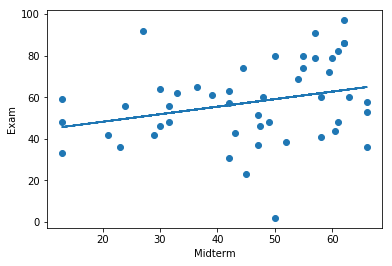

In [27]:
r_men = number1_3(men)

### Диаграмма рассеивания оценок у девочек с наложенной полученной прямой 

R^2 = 0.15120075533840516
y = 35.33220627710097 + 0.7564526120173446 * x + e


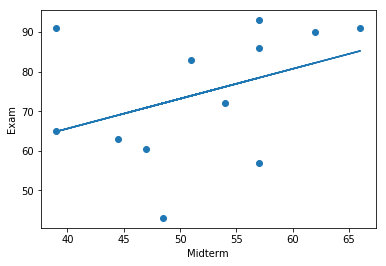

In [28]:
r_women = number1_3(women)

## Функция для проверки связи между оценками за к/р и экзамен
Пусть $H_0$ - гипотеза о том, что связь отсутсвует. $H_A$ - альтернатиивная гипотеза, говорящая о наличии связи.
### Вычисляется F статистика, которая равна

$F = \frac{R^2 / (k - 1)}{(1 - R^2) / (n - k)} = \frac{R^2 \cdot (n - k)}{(k - 1) \cdot (1 - r)}$ 

Для проверки гипотезы об отсутствии связи возьмем уровень значимости 5%.

_Если метод возвращает **True**, то $H_0$, которая говорит о том, что связь отсутствует, отвергается и нет оснований отвергнуть альтернативную гипотезу о том, что связь есть._

In [29]:
def check_connection(r, n, k):
    F = r * (n - k) / ((k - 1) * (1 - r))
    
    if n == men.shape[0]:
        F_5 = 4.06
    else:
        F_5 = 4.75
        
    print("{} и {}".format(F_5, F))
    return F_5 < np.abs(F)         # если true -- связь есть, H_0 отвергается 

### Проверка гипотезы для мальчиков

In [30]:
check_connection(r_men, men.shape[0], 2)

4.06 и 3.9525517362139038


False

#### Принимаем гипотезу о том, что связи между ними нет

### Проверка гипотезы для девочек

In [31]:
check_connection(r_women, women.shape[0], 2)

4.75 и 1.7813488441390746


False

#### Принимаем гипотезу о том, что связи между ними нет

## 5 Оценка модели 
$exam_i=\beta_1+\beta_2 \cdot midterm_i + \gamma_1 \cdot female_i + \gamma_2 female_i \cdot midterm_i+e_i$

Рассчет производится путем создания матрицы признаков X, состоящей из четырех столбцов: midterm, female, midterm * female и единичного столбца по формуле:

$\hat{\beta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$

In [34]:
# параметр - полная матрица

def number5(vec):                           
    y = vec["exam_9"]
    x1 = vec["midterm_9"]
    x2 = vec["female_9"]
    
    _vec = vec[["midterm_9", "female_9"]]
    _vec["female*midterm"] = _vec["female_9"] * _vec["midterm_9"]
    _vec["one"] = np.ones(_vec.shape[0])
    
    r = np.dot(np.linalg.inv(np.dot(np.array(_vec.T.values), np.array(_vec.values))), np.array(_vec.T.values))
    res = np.dot(r, y)
    
    y_0 = res[3] + res[0]*x1 + res[1]*x2 + res[2]*x1*x2
    e = y - (res[3] + res[0]*x1.mean() + res[1]*x2.mean() + res[2]*x1.mean()*x2.mean())
    
    return res, y_0

### Вывод результатов 

In [35]:
result, y_0 = number5(v)
print("exami = {} + {} × midterm_i + {} × female_i + {} × female_i × midterm_i + ε_i".format(result[3],result[0],result[1],result[2]))

exami = 40.96774429889814 + 0.36224480843946605 × midterm_i + -5.635538021798709 × female_i + 0.3942078035779111 × female_i × midterm_i + ε_i


## Проверка гипотезы о том, согласуются ли данные с утверждением, что регрессионная зависимость между оценками за экзамен и за контрольную одинакова для юношей и девушек 

$H_0: \gamma_1 = \gamma_2 = 0$ 

$H_A: \gamma_1^2 + \gamma_2^2 > 0$

Для этого вычислим коэффициент детерминации для ограниченной и неограниченной модели. 

Ограниченная модель: $exam_i=\beta_1+\beta_2 \cdot midterm_i + e_i$

Неограниченная модель $exam_i=\beta_1+\beta_2 \cdot midterm_i + \gamma_1 \cdot female_i + \gamma_2 female_i \cdot midterm_i+e_i$

In [36]:
y = v["exam_9"]
x1 = v["midterm_9"]
x2 = v["female_9"]

yaverage = y.mean()
y_0 = result[3] + result[0] * x1 + result[1] * x2 + result[2] * x1 * x2

tss = ((y - yaverage) ** 2).sum()
ess = ((y_0 - yaverage) ** 2).sum()
k = ess / tss

print("Коэффициент детерминации для неограниченной модели = {}".format(k))

Коэффициент детерминации для неограниченной модели = 0.19534266244033804


In [37]:
y_1 = result[3] + result[0] * x1

k_1 = np.corrcoef(y, y_1)[1,0] ** 2
print("Коэффициент детерминации для ограниченной модели = {}".format(k_1))

Коэффициент детерминации для ограниченной модели = 0.10779123664493656


In [38]:
F = (k - k_1) * (60 - 4)  / ((1 - k) * 2)
print("Значение статистики = {}".format(F))

Значение статистики = 3.04656380777672


### Критическое значение 

In [39]:
F_2_56 = 3.1

### $H_0$ принимается, то есть данные согласуются с утверждением, что регрессионная зависимость между оценками за экзамен и за контрольную одинакова для юношей и девушек

In [40]:
np.abs(F) < F_2_56

True